# High Level Overview

One of the first steps in this process is to extract the policies from these urban planning documents. While looking at the structure of these, for some documents, you may see a clear pattern, or predictable structure within them. We handled documents by matching the headings/sections and using regular expressions (RegEx), which allows us to pull out specific headings (like goals, policies, programs, etc.) that will be useful to us. In addition, the policies for other documents are structured into tabular format. There are several libraries in Python–for instance `pdfplumber`, `tabula`, and `camelot` to name a few–that allow us to pull tables that contain information on goals, plans, policies, and more.

**Note:** The human needs to identify whether the document is structured or unstructured, which changes which process to perform.

The Ruled-Based Extraction process involves first identifying the structure of the document, then using regular expressions to extract relevant sections such as goals, policies, and programs. I believe it would be helpful to show an example of this. Consider the Atascadero General Plan and the SLO County Multi-Jurisdictional Hazard Mitigation Plan documents.

## Rule-Based Policy Extraction: Example 1

**Example 1:** Atascadero General Plan
This can be split up by first, identifying the structure of  the document, then understanding what is needed to be able to perform policy extraction.


### 1. Analyzing the document visually


The Atascadero GP is 264 pages long, which compared to many other documents is not that much. Looking through the table of contents, and skimming through the pages, you can easily get a sense of how topics are structured throughout the document. Here are some things I noticed:
* In the table of contents, there are several “elements”, such as “Land Use, Open Space & Conservation Element”, “Circulation Element”, “Safety & Noise Element”, and “Housing Element”. These “elements” contain all the policies pertaining to that topic.
* Now looking at each ‘element’, there will be sections in the book where clearly defined are the goals, policies, and programs where each have a specific format.
  * Goals are typically structured with the abbreviation of the element and number afterwards like (Goal LOC 1 for Land Use, Open Space & Conservation and Goal CIR 3 for Circulation)
  * Policies are directly under goals (if there are any) with them including the goal number and policy number. So, this could be Policy 1.1, Policy 1.2 relating to Goal 1.
  * Programs are under each policy (if there are any). These policies are just a numbered list, and resets once there is another policy or goal.

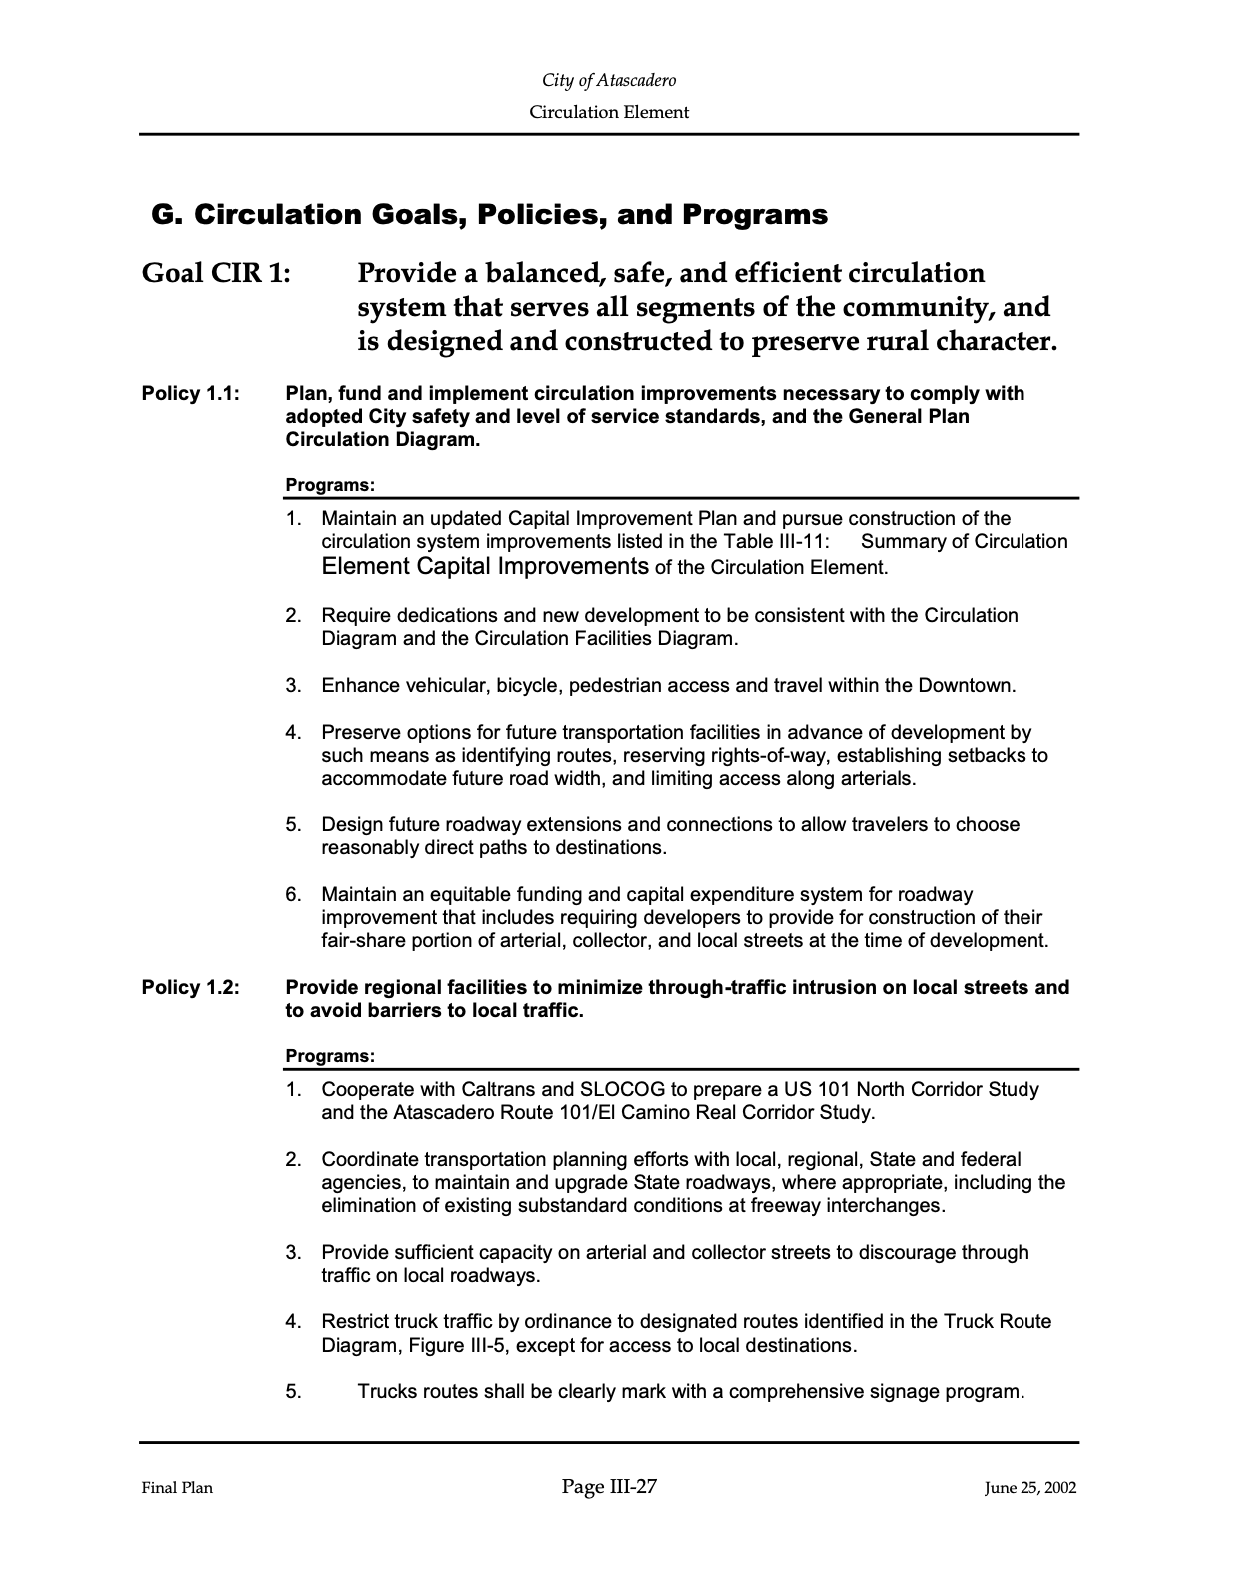

Above is an example of what a page with Goals, Policies, and Programs looks like in the Atascadero GP document.

With this in mind, we can now start to think about what sorts of regular expressions we can use and how to perform the extraction of the full text.

### 2. Writing the code

**Brief Overview / Components Needed**

1. **Open the PDF:** Using a natural language processing (NLP) library, the code reads the text from each page of the document.

2. **Identify Sections:** It identifies the relevant sections using regular expressions that match patterns in the text.

3. **Categorize Information:** As the text is processed, the code assigns extracted lines to relevant sections, depending on the content.

4. **Store and Structure Data:** The code maintains a matching structure (whether it's hierarchical or just a list of policies) and saves the information in an organized format for future use.

#### 1. Import libraries that are needed.

In [1]:
!pip install pdfplumber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 87.1 MB/s eta 0:00:00


In [2]:
# imports
# from pypdf import PdfReader
import pdfplumber
import re
import csv

#### 2. Identify Relevant Sections (if there are similar format)


Here are the regular expressions / regex codes for the goals, policies, and programs for the Atascadero GP:



In [3]:
# text patterns
goal_text = r"Goal (LOC|CIR|SFN|HOS) \d+"  # "Goal LOC {#}", "Goal CIR {#}", etc.
policy_text = r"^Policy \d+\.\d+"  # "Policy {#}.{#}"
program_text = r"^\d+\.\s"  # "1.", "2.", etc. at the start of the line for programs

Looking up documentation on how to use regular expressions will show what the syntax means, but these comments demonstrate how they are related.


#### 3. Open PDF & Extract Policies by Line-by-Line Parsing

Since the code is a big for loop, I left comments in the code block to demonstrate how the code works. But here are a few key ideas:

* **Opening and Reading the Document:** The code opens the Atascadero General
Plan PDF using `pdfplumber` library and reads through each page, extracting the text.

* **Line-by-Line Parsing:** Each page's text is split into lines. The code then checks each line to see if it matches one of the predefined regular expression patterns. These patterns are designed to identify goals, policies, and programs based on their structure in the document.

* **Goal, Policy, and Program Extraction:**
  * **Goal Detection:** When a goal is detected (e.g., "Goal LOC 1"), it starts a new "goal entry" and looks for policies that follow it.
  * **Policy Detection:** When a policy is detected (e.g., "Policy 1.1"), it starts a new "policy entry" under the most recent goal.
  * **Program Detection:** When a program is detected (e.g., "1. Establish wildfire risk zones"), it adds the program under the most recent policy.

* **Handling Multi-Line Entries:** Some goals, policies, or programs may span multiple lines. The code accumulates text for these entries and saves them once they are complete (for example, when a line ends with a period).

In [4]:
extracted = [] # store extracted text

with pdfplumber.open('1 Atascadero GP 2025.pdf') as general:
    for page_num, page in enumerate(general.pages, start=1):
        gen_text = page.extract_text()

        if not gen_text:  # if no text on the page, skip
            continue

        lines = gen_text.split("\n")
        current_goal = None
        current_policy = None
        temp_goal = ""  # temp storage for accumulating goal text
        temp_policy = ""  # temp storage for accumulating policy text
        temp_program = ""  # temp storage for accumulating program text
        current_programs = []  # store programs under a policy

        # process lines
        for line in lines:
            line = line.strip()

            # detect new goal
            if re.match(goal_text, line):
                if current_goal: # append to prev goal data if ongoing goal
                    extracted.append({
                        "page": page_num,
                        "goal": temp_goal.strip(),
                        "policies": current_programs
                    })
                # start new goal
                current_goal = line
                temp_goal = line  # start accumulating goal text
                current_programs = []  # reset programs for new goal

            # detect new policy
            elif re.match(policy_text, line):
                if current_policy: # append to prev policy if ongoing policy
                    extracted.append({
                        "page": page_num,
                        "policy": temp_policy.strip(),
                        "programs": current_programs
                    })
                # start new policies
                current_policy = line
                temp_policy = line  # start accumulating policy text
                current_programs = []  # reset programs for new policy

            # detect new program
            elif re.match(program_text, line):
                if temp_program:
                    current_programs.append(temp_program.strip())  # append previous program
                temp_program = line  # start accumulating program text

            # accumulate goal or policy text
            elif current_goal and not re.match(policy_text, line) and not re.match(goal_text, line):
                temp_goal += " " + line  # append to goal text
                if line.endswith("."):
                    # save goal text when it ends with a period
                    extracted.append({
                        "page": page_num,
                        "goal": temp_goal.strip(),
                        "policies": current_programs
                    })
                    temp_goal = ""  # reset goal text after saving
                    current_goal = None  # reset the current goal

            elif current_policy and not re.match(goal_text, line) and not re.match(program_text, line):  # ensure not capturing a new goal
                temp_policy += " " + line  # append to policy text
                if line.endswith("."):
                    # save policy text when it ends with a period
                    extracted.append({
                        "page": page_num,
                        "policy": temp_policy.strip(),
                        "programs": current_programs
                    })
                    temp_policy = ""  # reset policy text after saving
                    current_policy = None  # reset current policy

            # cont accumulating program text until a period is encountered
            elif temp_program:
                temp_program += " " + line  # append to program text
                if line.endswith("."):
                    current_programs.append(temp_program.strip())  # add program when it ends
                    temp_program = ""  # reset program text after saving
                    continue  # proceed to next program

        # end of the page or document, append any remaining data
        if temp_program:
            current_programs.append(temp_program.strip())
        if current_policy:
            extracted.append({
                "page": page_num,
                "policy": temp_policy.strip(),
                "programs": current_programs
            })
        if current_goal:
            extracted.append({
                "page": page_num,
                "goal": temp_goal.strip(),
                "policies": current_programs
            })

FileNotFoundError: [Errno 2] No such file or directory: '1 Atascadero GP 2025.pdf'

**Final Cleanup:** After the last page is processed, the code ensures that any dangling or incomplete entries are saved.

#### 4. Saving and Structuring Data

The data for each goal, policy, and program is saved in a structured (hierarchical) format, which allows for easy access and further analysis.

Each goal has associated policies, and each policy can have associated programs.

In [ ]:
# save to CSV

csv_filename = 'atascadero_gp_policies.csv'

with open(csv_filename, mode='w', newline='', encoding='utf-8') as csv_file:
    fieldnames = ['page', 'goal', 'policy', 'programs']

    # capitalize headers
    capitalized_fieldnames = [field.upper() for field in fieldnames]
    writer = csv.DictWriter(csv_file, fieldnames=capitalized_fieldnames)

    # write header
    writer.writeheader()

    # write rows
    for item in extracted:
        row = {
            "PAGE": item['page'],
            "GOAL": item.get('goal', ''),
            "POLICY": item.get('policy', ''),
            "PROGRAMS": "; ".join(item.get('programs', []))  # Join programs into a single string
        }
        writer.writerow(row)

print(f"Data saved to {csv_filename}")

### Limitations

There are some limitations to this technique however:
* This extraction script works best when documents follow a predictable structure, but in practice, urban planning documents vary widely in formatting. Each new document may require custom adjustments to the regular expression patterns, as headings and numbering schemes can differ.
* While the script typically runs in under a few minutes for most documents, very long PDFs may take longer.
* Multi-line entries are handled using a basic heuristic (accumulating text until a period is found), which may not always capture full thoughts if punctuation is inconsistent.


## Rule-Based Policy Extraction: Example 2

**Example 2:** Napa Hazard Mitigation Plan

Similarly to the Atascadero General Plan, scanning through the document and examining the structure of the policies is a good place to start. However, when the policies are organized in a tabular format, the steps to extract them out of a document look a little bit different.

### 1. Analyzing the Document

In the Hazard Mitigation Plan, each section of policies is organized into a table. While the content of each table differs throughout the document, each one has a title, goal/policy number column, and a description column. Some of the policies just have the number and texts in their tables, while others have columns for hazards that are mitigated, departments working on enacting these policies, or the estimated cost of implementing the policy. Regardless, utilizing the table extraction packages in Python allows us to pull each one into a more concise and organized format.

### 2. Writing the Code

This process can be broken down into opening the pdf, extracting the tables from each page of the pdf, and saving and organizing the results in a new csv file.



*   To prepare the pdf, you will need the path to the file on your local drive, a library of your choice (pdfplumber, tabula, camelot, etc.) to open it, and any additional table settings that will format the table in a more visually appealing manner.
*   First, import the necessary Python libraries.




In [ ]:
import warnings
warnings.filterwarnings('ignore')
!pip install pdfplumber

In [ ]:
import pdfplumber
import pandas as pd
import csv
import requests
import os
import io



*   Next, establish the path to the location where your document is stored locally. You will have to upload the local file you are working with to Google Drive.



In [ ]:
# Napa Hazard Plan URL: https://drive.google.com/file/d/1uwfq7JZkkrbzZQlsCwbHSNAHE3VFRUB8/view?usp=sharing

file_id = '1uwfq7JZkkrbzZQlsCwbHSNAHE3VFRUB8'  # Google Drive File ID
url = f'https://drive.google.com/uc?export=download&id={file_id}'

In [ ]:
try:
    response = requests.get(url, stream=True)
    response.raise_for_status()

    hazard_plan_pdf_content = io.BytesIO(response.content)

    hazard_plan_pdf = pdfplumber.open(hazard_plan_pdf_content)


except requests.exceptions.RequestException as e:
    print(f"Error downloading the file: {e}")
except Exception as e:
    print(f"An error occurred: {e}")



*   The code below will mount your Google Drive. The purpose of this is to allow you to sync your local files through Google Drive so you can access them on the cloud drive.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')



*   The next step is to pinpoint where the policy tables you need are located and extract them. After scanning through the SLO Hazard Mitigation Plan, I found that all the policies were after page 311, which gave me less of the document to explore and saved time. I then used the corresponding table extraction functions to pull tables from each page and save them into data frames. You may have to modify the this code to account for differences in other city planning documents, as not all of them will have their policies concentrated in the same area.
*   Note: the code below may take some time to run! This is completely normal.



In [ ]:
tables = []
for page in range(342, 352):
    table=hazard_plan_pdf.pages[page].extract_table()

    if table is not None and len(table) > 2:
        data = table[1::]
        columns = table[0]
        desired_column_headers = ["Mitigation\n No.", "Hazard\n Type", "Description"]
        dataframe = pd.DataFrame(data, columns=columns)

        actual_columns = dataframe.columns.tolist()
        matched_columns = [col for col in actual_columns if col in desired_column_headers]
        dataframe = dataframe.loc[:, matched_columns]

        tables.append(dataframe)



*   The last step is organizing the policies into a new document, in this case a csv file. I imported the csv package into Python, which contains functions for reading and writing to a csv file. Using the writerow and writerows functions in Python, the headings and text content of each table of policies are written to a new line of the file.



In [ ]:
def add_tables_to_csv(tables, filename):
    with open(filename, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)

        for table in tables:
            if not table.empty:

                if table.iloc[0].nunique() == len(table.iloc[0]):
                    table.columns = table.iloc[0]
                    table = table[1:]

                writer.writerow(table.columns)
                writer.writerows(table.values)
                writer.writerow([])


In [ ]:
file = "napa_hazard_plan_tables.csv"
csv_filename = '/content/drive/MyDrive/' + file
add_tables_to_csv(tables, csv_filename)
print(f"Tables saved to {csv_filename}")

### Challenges and Limitations

While this table extraction technique efficiently pulls policies in minimal lines of code, it also has its drawbacks to be aware of:



*   **Not all the tables in the document were relevant.** After scraping the tables from the SLO County Hazard Mitigation Plan, we realized that some of the tables included additional information that was unrelated to prevention measures. This created a little bit more work manually removing the extra tables from our final csv file.
*   **Some of the policy tables are different from the others.** This makes for formatting issues when the policies are extracted to the final csv. There may be large gaps of white space within a table or between tables that will need to be manually cleaned up.

